# Dead Reckoning In 3D

In this exercise, the drone moves in a 3D environment on a periodic path. The state is inferred from IMU measurements. These measurements are obtained through gyroscope and accelerometer sensors. The gyroscope outputs $\theta$ and $\phi$ while the accelerometer outputs $a_x$, $a_y$ and $a_z$ in the body frame. 

The state vector for the object can be expressed as $X=[x,y,z,\theta,\phi,\dot{x},\dot{y},\dot{z}]$. **We'll assume $\psi$ is always 0.**

<img src="Drone3D2.png" width="600">

In [122]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
import math
from math import sin, cos, tan
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import jdc
import random
from test_three_d_object import TestCode

pylab.rcParams['figure.figsize'] = 10, 10

First, we describe the properties of the object and all the functions that it will need to track its position based on the IMU measurements. The state function tracks the position, velocity in three dimensions and the attitude of the drone $X=[x,y,z,\theta,\phi,\dot{x},\dot{y},\dot{z}]$. We also would require the function which will provide us with the rotation matrix allowing us to transform the state, measured in body frame, into the global frame (`rotation_matrix` is already provided). 

The conversion of the instantaneous turn rate in the body frame to an instantaneous change in the Euler angles is achieved by matrix multiplication.

$$
\begin{pmatrix} \dot{\phi} \\ \dot{\theta} \end{pmatrix} = \begin{pmatrix} 1 & \sin{\phi}\tan{\theta} \\ 0 & \cos{\phi}  \end{pmatrix} \times \begin{pmatrix} p \\ q  \end{pmatrix}
$$

`advance_state` updates the position of, and then the attitude of the drone.

**NOTE:** The chosen method is the simplest to illustrate but it generates the biggest computational error. We encourage you to explore other computational integration methods. 


In [164]:
class ObjectInThreeD:
    
    def __init__(self):
        '''
        Initialize the object with zero state space and the gravity constant
        '''
        
        self.X = np.zeros((8, 1))
        self.g = 9.81 * np.array([[0], [0], [-1]])# The opposite of the gravity thus directed opposite of the z-axis. 
        
    
    def rotation_matrix(self, phi, theta):
        '''
        Generates the rotation matrix for the given roll and pitch angles
        The yaw angle is assumed to be equal to zero. 
        '''
        
        psi = 0.0 
        r_x = np.array([[1, 0, 0],
                        [0, np.cos(phi), -np.sin(phi)],
                        [0, np.sin(phi), np.cos(phi)]])

        r_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                        [0, 1, 0],
                        [-np.sin(theta), 0, np.cos(theta)]])

        r_z = np.array([[np.cos(psi), -np.sin(psi), 0],
                        [np.sin(psi), np.cos(psi), 0],
                        [0, 0, 1]])

        r = np.matmul(r_z, np.matmul(r_y, r_x))

        return r 


    def get_euler_derivatives(self, phi, theta, p, q):
        '''
        Converts the measured body rates into the Euler angle derivatives using the estimated pitch and roll angles.
        '''
        # TODO: Calculate the Derivatives for the Euler angles in the inertial frame 
        euler_rot_mat= np.array([[1, sin(phi) * tan(theta)], [0, cos(phi)]])
        derivatives_in_bodyframe = np.array([p, q])
        euler_dot = np.matmul(euler_rot_mat, derivatives_in_bodyframe)
        return euler_dot


    def linear_acceleration(self, measured_acceleration, phi, theta):
        '''
        Calculates the true accelerations in the inertial frame of reference based 
        on the measured values and the estimated roll and pitch angles. 
        '''
        # TODO: Calculate the true acceleration in body frame by removing the gravity component
        rot_mat = self.rotation_matrix(phi, theta)
        a_body_frame = measured_acceleration - np.matmul(rot_mat, self.g)
        # TODO: Convert the true acceleration back to the inertial frame
        a_inertial_frame = np.linalg.solve(rot_mat, a_body_frame)

        return a_inertial_frame
    
    def dead_reckoning_orientation(self, p, q, dt):
        '''
        Updates the orientation of the drone for the measured body rates
        '''
        # TODO: Update the state vector component of roll and pitch angles
        phi = self.X[4]
        theta = self.X[3]

        euler_dot = self.get_euler_derivatives(phi, theta, p, q)
        self.X[3] = self.X[3] + euler_dot[1] * dt         # integrating the roll angle 
        self.X[4] = self.X[4] + euler_dot[0] * dt         # integrating the roll angle 
        
        
    def dead_reckoning_position(self, measured_acceleration, dt):
        '''
        Updates the position and the linear velocity in the inertial frame based on the measured accelerations
        '''
        perceived_phi = self.X[4]
        perceived_theta = self.X[3]

        # TODO: Conver the body frame acceleration measurements back to the inertial frame measurements
        a = self.linear_acceleration(measured_acceleration, perceived_phi, perceived_theta)

        # TODO: 
        # Use the velocity components of the state vector to update the position components of the state vector
        # Use the linear acceleration in the inertial frame to update the velocity components of the state vector

        self.X[0] = self.X[0] + self.X[5] * dt   # x coordinate x = x + \dot{x} * dt
        self.X[1] = self.X[1] + self.X[6] * dt   # y coordinate y = y + \dot{y} * dt
        self.X[2] = self.X[2] + self.X[7] * dt   # z coordinate z = z + \dot{z} * dt
        self.X[5] = self.X[5] + a[0] * dt   # change in velocity along the x is a_x * dt 
        self.X[6] = self.X[6] + a[1] * dt   # change in velocity along the y is a_y * dt 
        self.X[7] = self.X[7] + a[2] * dt   # change in velocity along the z is a_z * dt 
        
    def advance_state(self, measured_acceleration, p, q, dt): 
        '''
        The function of the advance state updated the position of the drone 
        in the inertial frame and then the drone attitude.
        '''

        # Advance the position 
        self.dead_reckoning_position(measured_acceleration, dt)

        # Advance the attitude 
        self.dead_reckoning_orientation(p, q, dt)

        return self.X 

We can test `linear_acceleration` to make sure it calculates the linear acceleration in the inertial frame based on the measured acceleration, and roll/pitch angles in the body frame.

In [165]:
phi_test = 0.1 
theta_test = 0.1
measured_acceleration = np.array([[0.1], [0.2], [10.1]])
ThreeDObject = ObjectInThreeD()

TestCode.test_the_linear_acceleration(ThreeDObject.linear_acceleration(measured_acceleration, 
                                                                       phi_test, 
                                                                       theta_test),
                                      measured_acceleration, phi_test, theta_test)

Test passed


We will load the periodic motion path that will be used to generate the flight path. The roll and pitch angles are calculated based on the path and represent the true values that the drone should have had in order to execute the given flight. 

In [166]:
from flightpath3D import flight_path
t, dt, x, x_dot, x_dot_dot, y, y_dot, y_dot_dot, z, z_dot, z_dot_dot, phi, phi_dot, theta, theta_dot = flight_path()

Plotting the executed path.

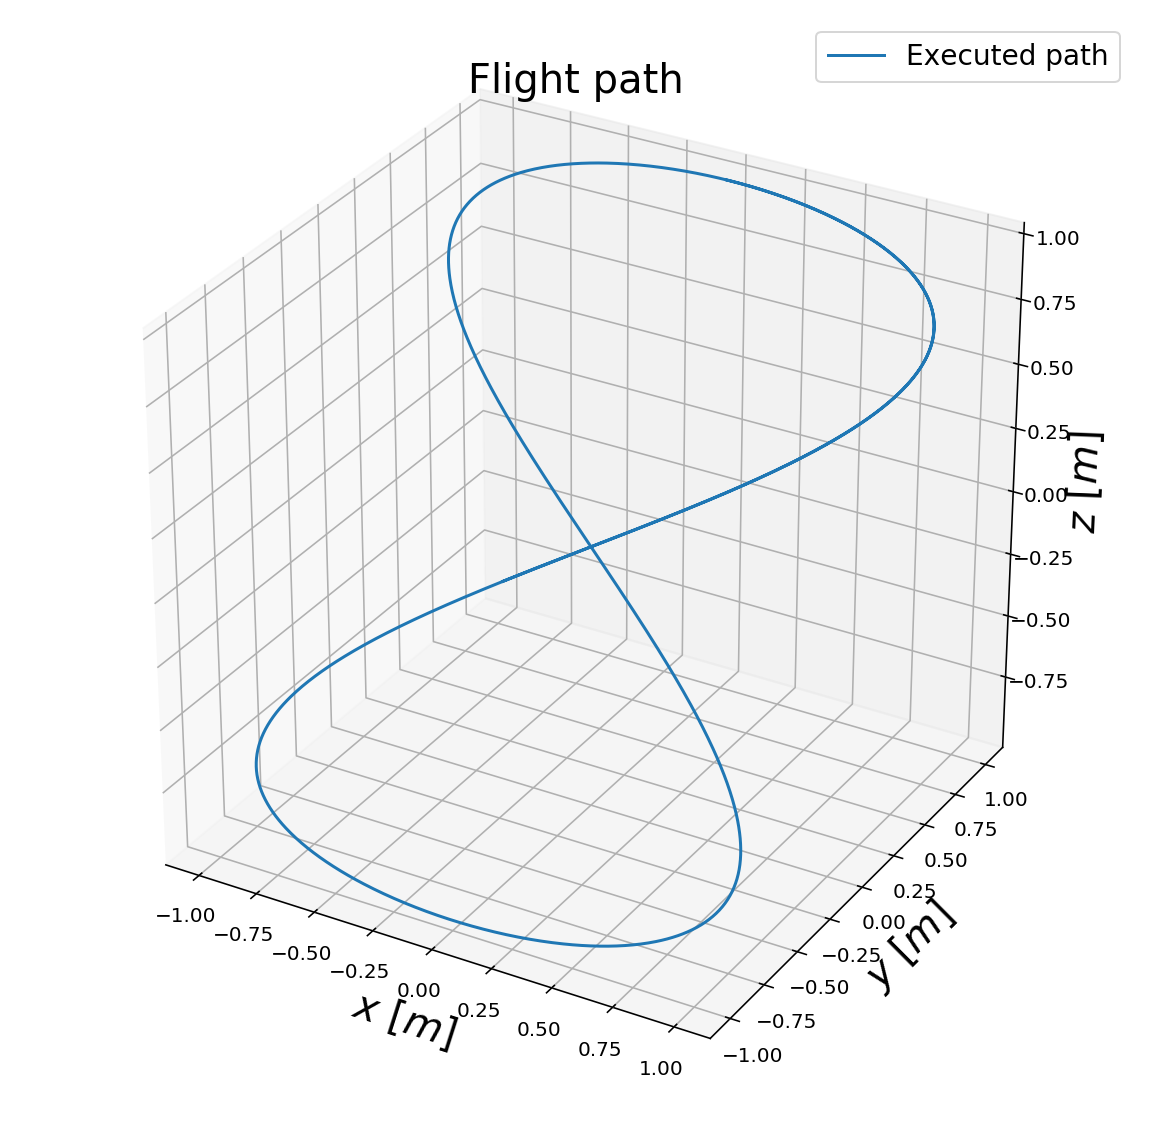

In [167]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x, y, z)
plt.title('Flight path').set_fontsize(20)
ax.set_xlabel('$x$ [$m$]').set_fontsize(20)
ax.set_ylabel('$y$ [$m$]').set_fontsize(20)
ax.set_zlabel('$z$ [$m$]').set_fontsize(20)
plt.legend(['Executed path'],fontsize = 14)

plt.show()

# IMU 
We will create the IMU class which will simulate the sensor measurements. Doing this we will get a better understanding of the underlying mathematics. 
We declare the acceleration and angular velocity measurement uncertainties for our sensor, and introduce the gravity vector which is directed up $\vec{g}=[0,0,-g]$ as the IMU measures reactive force against the gravity which is directed up. 

The Linear acceleration can be modeled as 

$$
a_{effective} = a^{(g)}+a^{(l)}
$$

where $a^{(g)}$ is the acceleration associated with the reactive force due to gravity and $a^{(l)}$ motion acceleration in the inertial frame. 

Knowing the real $\phi$ and $\theta$, the effective acceleration can be converted into a body frame $a_{body}$
after transformation noise can be added.

$$
\tilde{a}_{body} = a_{body} + \eta_{a}, \quad \eta_{a} \sim N(0,\sigma^2_{a})
$$

The conversion of the instantaneous turn rate in the body frame to an instantaneous change of the Euler angles is obtained by matrix multiplication.

$$
\begin{pmatrix} \dot{\phi} \\ \dot{\theta} \end{pmatrix} = \begin{pmatrix} 1 & \sin{\phi}\tan{\theta} \\ 0 & \cos{\phi}  \end{pmatrix} \times \begin{pmatrix} p \\ q  \end{pmatrix}
$$

Expressing the conversion matrix as 

$$
R_{gyro} = \begin{pmatrix} 1 & \sin{\phi}\tan{\theta} \\ 0 & \cos{\phi}  \end{pmatrix}
$$

Thus 
$$
R_{gyro}^{-1}\begin{pmatrix} \dot{\phi} \\ \dot{\theta} \end{pmatrix} = R_{gyro}^{-1} R_{gyro} \begin{pmatrix} p \\ q  \end{pmatrix} = I \begin{pmatrix} p \\ q  \end{pmatrix} 
$$

The final equation shows that knowing the roll and pitch angles, we can calculate the angular velocities in body frames if we know the change in the attitude. 

In [168]:
class IMU:
    
    def __init__(self,
                 sigma_a = 0.0001,          # An error of acceleration measurement
                 sigma_omega = 0.00001      # An error of angular velocity measurement
                ):
        '''
        Initializing the IMU object with the sigma values associated 
        to the measuring the accelerations in the body frame and 
        the angular velocities p, q, and r. Even though that in this 
        exercise we assume yaw is zero for all times.
        '''
        self.sigma_a  = sigma_a
        self.sigma_omega = sigma_omega
        self.g = 9.81 * np.array([[0], [0], [-1]]) # The opposite of the gravity thus directed opposite of the z-axis. 
    
    def rotation_matrix(self,phi,theta):
        '''
        Returns the rotation matrix for the given roll and pitch angles (Yaw is zero).
        '''
        
        psi = 0.0 
        r_x = np.array([[1, 0, 0],
                        [0, np.cos(phi), -np.sin(phi)],
                        [0, np.sin(phi), np.cos(phi)]])

        r_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                        [0, 1, 0],
                        [-np.sin(theta), 0, np.cos(theta)]])

        r_z = np.array([[np.cos(psi), -np.sin(psi), 0],
                        [np.sin(psi), np.cos(psi), 0],
                        [0,0,1]])

        r = np.matmul(r_z,np.matmul(r_y,r_x))

        return r 
    
    def accelerometer_measurement(self, actual_a, phi, theta):
        '''
        Simulates the measurements of the accelerations in the body frame 
        based on the actual linear acceleration and for the actual roll and pitch angles.
        '''
        # TODO: Convert global frame acceleration into the body frame acceleration
        actual_a = actual_a.reshape(3, 1)
        R = self.rotation_matrix(phi, theta)
        linear_acc_bodyframe = np.matmul(R, actual_a)

        # TODO: Gravity component of the measurement
        gravity_component = np.matmul(R, self.g)

        # TODO: Error component of the measurement
        error_component = np.random.normal(0, self.sigma_a, (3, 1))

        measured_acceleration = linear_acc_bodyframe + gravity_component + error_component

        return measured_acceleration
    
    def gyroscope_measurement(self, phi, theta, phi_dot, theta_dot):
        '''
        Simulates the gyroscope measurements for the actual change in roll and pitch angles.
        '''
        # TODO: Implement the Conversion matrix 
        R = np.array([[1, sin(phi) * tan(theta)], [0, cos(phi)]])

        # TODO: Calculate the body rate p and q true values 
        #body_rate = np.linalg.solve(R, np.array([phi_dot, theta_dot]).reshape(2, 1))
        body_rate = np.matmul(np.linalg.inv(R) , np.array([[phi_dot], [theta_dot]]))

        # TODO: Add an error to the true body rates
        measured_bodyrates = body_rate + np.random.normal(0, self.sigma_omega)

        return measured_bodyrates

Testing `accelerometer_measurement` and `gyroscope_measurement`.

In [169]:
phi_test = 0.1 
theta_test = 0.1
acceleration = np.array([[0.1], [0.2], [0.3]])
ThreeDObject = IMU()

TestCode.test_the_accelerometer_measurement(ThreeDObject.accelerometer_measurement(acceleration, 
                                                                                   phi_test, 
                                                                                   theta_test),
                                      acceleration, phi_test, theta_test)

Test passed


Testing  `gyroscope_measurement`.

In [170]:
phi_test = 0.1 
theta_test = 0.1
phi_dot_test = 0.3 
theta_dot_test = 0.2
ThreeDObject = IMU(sigma_omega=0.0)

TestCode.test_the_gyroscope_measurement(ThreeDObject.gyroscope_measurement(phi_test,
                                                                           theta_test,
                                                                           phi_dot_test,
                                                                           theta_dot_test),
                                        phi_test, theta_test, phi_dot_test, theta_dot_test)

Test passed


Using all the functions that we've have implemented above let's set the drone in motion and record the state history.

In [171]:
DroneIMU =IMU()
Drone = ObjectInThreeD()
Drone.X = np.array([x[0], y[0], z[0], theta[0], phi[0], x_dot[0], y_dot[0], z_dot[0]])

state_histroy = Drone.X 
actual_a = np.vstack((np.vstack((x_dot_dot, y_dot_dot)), z_dot_dot))
for i in range(phi.shape[0]):
    measured_acceleration = DroneIMU.accelerometer_measurement(actual_a[:,i], phi[i], theta[i])
    measured_bodyrates = DroneIMU.gyroscope_measurement(phi[i], theta[i], phi_dot[i], theta_dot[i])
    p = measured_bodyrates[0]
    q = measured_bodyrates[1] 
    
    state_of_drone = Drone.advance_state(measured_acceleration, p, q, dt)
    state_histroy = np.vstack((state_histroy,state_of_drone))


Plotting the two paths.

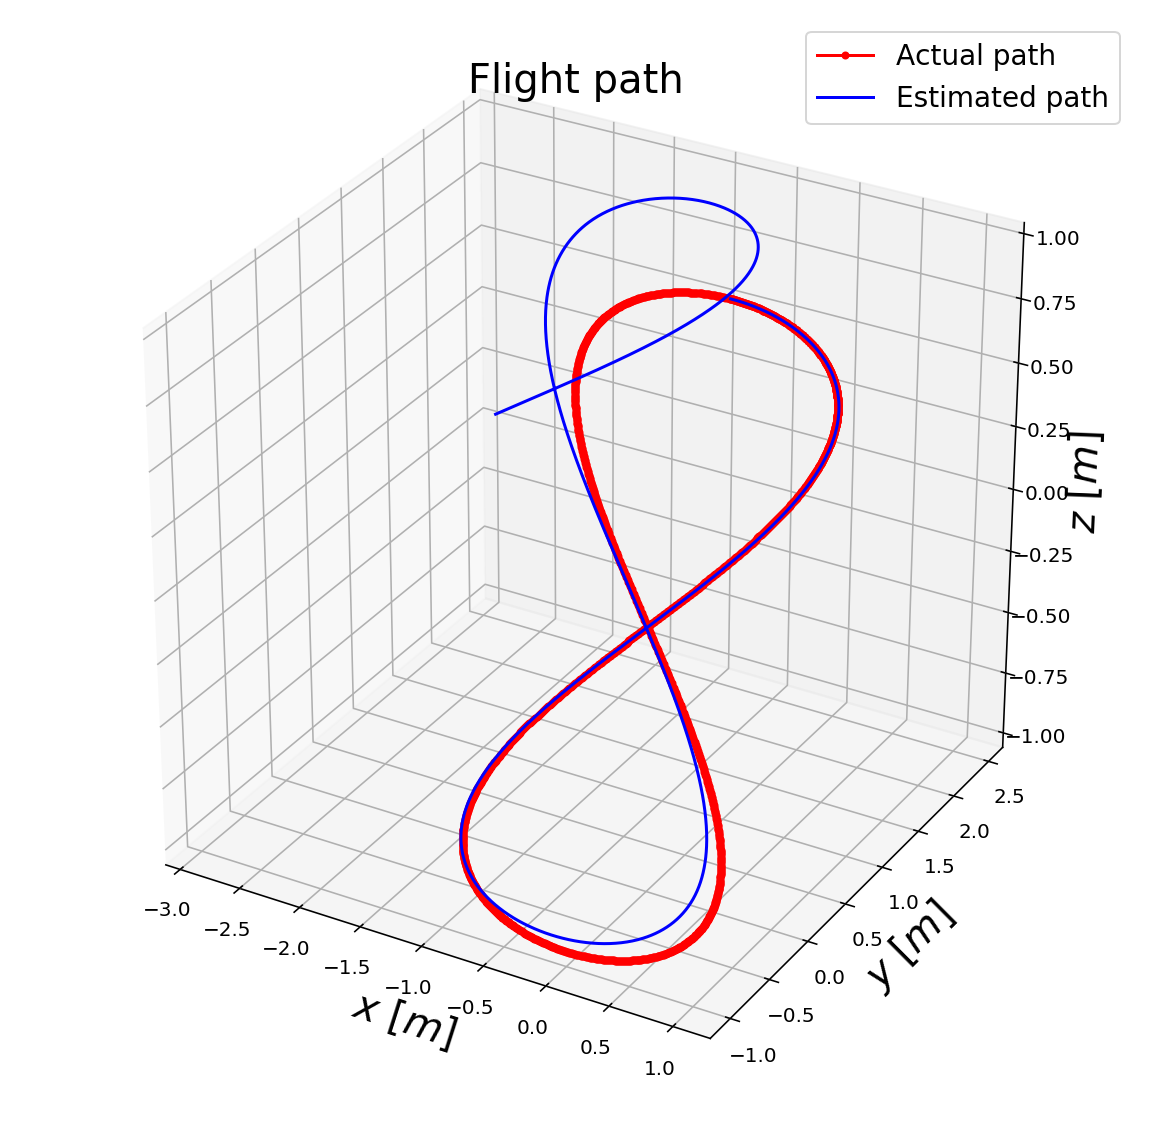

In [172]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x, y, z,color ='red',marker='.')
ax.plot(state_histroy[:,0], state_histroy[:,1], state_histroy[:,2],color ='blue')
plt.title('Flight path').set_fontsize(20)
ax.set_xlabel('$x$ [$m$]').set_fontsize(20)
ax.set_ylabel('$y$ [$m$]').set_fontsize(20)
ax.set_zlabel('$z$ [$m$]').set_fontsize(20)
plt.legend(['Actual path','Estimated path'],fontsize = 14)

plt.show()

[Solution](./Dead_Reckoning_3D-Solution.ipynb)